In [ ]:
# Loading Libraries
###### NOTE ##### Executed in Google Colab
#--------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers
#--------------------------------
import numpy as np
import matplotlib.pyplot as plt
import cv2
#--------------------------------
from skimage.transform import resize
import urllib.request
#--------------------------------
###### NOTE ##### If you use Colab
#--------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data; Data augmentation

In [ ]:
# Data preprocessing
#--------------------------------
###### NOTE ##### Change PATH(base_dir) to your choice!
base_dir = '/content/drive/MyDrive/DATA/final_data'
#--------------------------------
# Data augmentation
#--------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

###### NOTE ##### The validation data should not be augmented!
###### NOTE ##### Target size needs to be adjusted to pretrained model used for transfer learning

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    subset='training',
    target_size=(224, 224),
    seed=0,
    batch_size=50,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    base_dir,
    subset='validation',
    target_size=(224, 224),
    seed=0,
    batch_size=50,
    class_mode='categorical')

Found 2000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [ ]:
print(train_generator.class_indices)

{'0_selfie_indoor': 0, '1_selfie_outdoor': 1, '2_pose_indoor': 2, '3_pose_outdoor': 3, '4_without_human': 4}


# Model architecture

In [ ]:
# Model architecture; using MobileNet for transfer learning
#--------------------------------

from tensorflow.keras.applications.mobilenet import MobileNet

base_mn = MobileNet(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

#base_mn.summary()
base_mn.trainable = False

model_mn = models.Sequential()
#model_mn.add(layers.InputLayer(input_shape=(224,224,3)))
model_mn.add(base_mn)
model_mn.add(layers.Flatten())
model_mn.add(layers.Dense(256, activation='relu'))
model_mn.add(layers.Dense(5, activation='softmax'))

model_mn.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc', 'AUC'])

# Training the model

In [ ]:
# callback to save the trained model to GoogleDrive
callback_1 = ModelCheckpoint('/content/drive/MyDrive/DATA/final_model/model_mn7.pt',
							  monitor='val_acc',
							  save_best_only = True,
							  mode='max',
							  verbose=2)

# callback to prevent overfitting
callback_2 = EarlyStopping(patience = 20)
callback_list = [callback_1, callback_2]

history = model_mn.fit(
      train_generator,
      steps_per_epoch=15,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2,
      callbacks=callback_list)

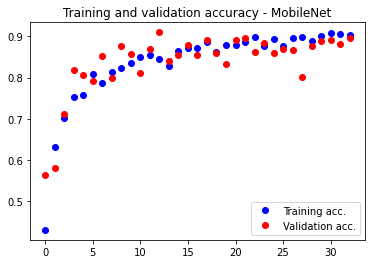

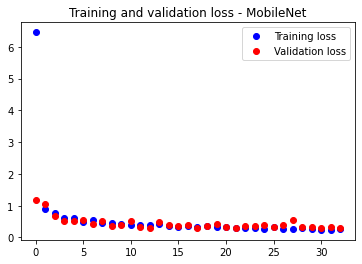

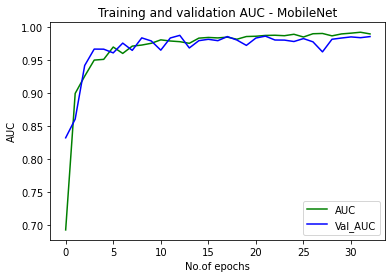

<Figure size 432x288 with 0 Axes>

In [ ]:
# PLOTTING THE HISTORY

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
AUC = history.history['auc']
val_AUC = history.history['val_auc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc.')
plt.plot(epochs, val_acc, 'ro', label='Validation acc.')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy - MobileNet')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss - MobileNet')
plt.legend()
plt.figure()

plt.plot(epochs, AUC, 'g', label='AUC')
plt.plot(epochs, val_AUC, 'b', label='Val_AUC')
plt.xlabel('No. of epochs')
plt.ylabel('AUC')
plt.title('Training and validation AUC - MobileNet')
plt.legend()
plt.figure()

plt.show()

###Loading the best model

In [ ]:
# Import best model
from keras.models import load_model
best_model = load_model('/content/drive/MyDrive/DATA/final_model/model_mn7.pt')

#Model evaluation

In [ ]:
# set val_datagen shuffle to False

val_gen_noshuffle = val_datagen.flow_from_directory(
        base_dir,
        subset='validation',
        target_size=(224, 224),
        batch_size=1,
        shuffle=False,
        class_mode='categorical')

Found 500 images belonging to 5 classes.


#### Classification report and confusion matrix

In [ ]:
# this ensures we start from first batch
val_gen_noshuffle.reset()

# import classification_report
from sklearn.metrics import confusion_matrix, classification_report

# get the ground truth of your data
test_labels = val_gen_noshuffle.classes 

# predict the probability distribution of the data
probabilities = best_model.predict(val_gen_noshuffle, steps=500, verbose=1)

# get the class with highest probability for each sample
y_pred = np.argmax(probabilities, axis=-1)

# get the classification report
print('----- Classification Report -----')
print(classification_report(test_labels, y_pred, target_names = ['Selfie indoor', 'Selfie outdoor', 'Pose indoor', 'Pose outdoor', 'Without human']))

# get the confussion matrix
print('----- Confusion Matrix -----')
import pandas as pd
pd.DataFrame(confusion_matrix(test_labels, y_pred))

500/500 [==============================] - 30s 61ms/step
----- Classification Report -----
                precision    recall  f1-score   support

 Selfie indoor       0.95      0.83      0.89       100
Selfie outdoor       0.88      0.94      0.91       100
   Pose indoor       0.85      0.92      0.88       100
  Pose outdoor       0.90      0.90      0.90       100
 Without human       0.98      0.96      0.97       100

      accuracy                           0.91       500
     macro avg       0.91      0.91      0.91       500
  weighted avg       0.91      0.91      0.91       500

----- Confusion Matrix -----


,0,1,2,3,4
0,83,8,8,0,1
1,2,94,1,3,0
2,2,0,92,5,1
3,0,5,5,90,0
4,0,0,2,2,96


#### Multiclass ROC AUC score

ROC AUC score: 0.9869749999999999


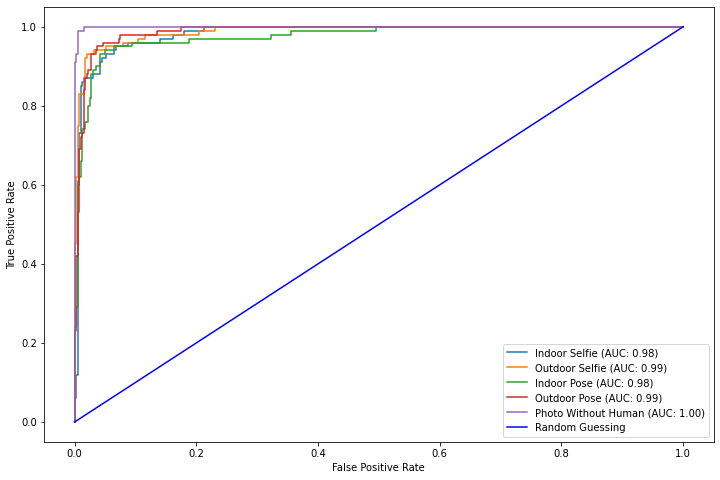

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_test = val_gen_noshuffle.classes 
target= ['Indoor Selfie', 'Outdoor Selfie', 'Indoor Pose', 'Outdoor Pose', 'Photo Without Human']

# figure size
fig, c_ax = plt.subplots(1, 1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, probabilities, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), probabilities[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, probabilities, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(test_labels, probabilities))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# Testing the model

### A function to output probability of each class for a given image

In [ ]:
# define class names
classes = ['Indoor Selfie', 'Outdoor Selfie', 'Indoor Pose', 'Outdoor Pose', 'Photo Without Human']

In [ ]:
# Manually testing an image from URL
#--------------------------------
###### NOTE ##### Change URL to your choice!
#--------------------------------
def image_from_url(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_preprocessed  = cv2.resize(image, (224,224))
    return image_preprocessed

def show_pred_img(url):
    image_preprocessed = image_from_url(url)
    plt.axis("off") 
    plt.title("TEST PHOTO:")
    img = plt.imshow(image_preprocessed)
    image_preprocessed = np.expand_dims(image_preprocessed, axis=0)/255
    predictions = best_model.predict(image_preprocessed)
    class_index = [0,1,2,3,4]
    print("------------------------------ ")
    print("PREDICTIONS:")
    print("------------------------------ ")
    for i in range (5):
      for j in range (5):
        if predictions[0][class_index[i]] > predictions[0][class_index[j]]:
          temp = class_index[i]
          class_index[i] = class_index[j]
          class_index[j] = temp
    ###### NOTE #####  Print the predictions in order
    for i in range(5):
      print(classes[class_index[i]], ":", round( predictions[0][class_index[i]] * 100), "%")
    
    
    print("------------------------------ ")


### Predictions

In [ ]:
# Examples
#--------------------------------
### NOTE ### Simply remove comment or add as needed.
### NOTE ### If you test another one, would be nice to save here.
#--------------------------------

#Indoor Selfie testing
#--------------------------------
#show_pred_img("https://static.hub.91mobiles.com/wp-content/uploads/2016/08/Indoor-nexus-6p.jpg")
#show_pred_img("https://pics.me.me/selfie-time-i-feel-and-look-dead-inside-58141424.png")
#show_pred_img("https://cdn.shortpixel.ai/client2/q_lossy,ret_img,w_1000,h_642/https://www.pixinfocus.com/wp-content/uploads/2020/03/selfie-ideas-103.jpg")
#show_pred_img("https://i.pinimg.com/originals/7e/46/a5/7e46a58bc6df64fd396d0ac2fbc36715.jpg")

#Outdoor Selfie testing
#--------------------------------
#show_pred_img("https://ichef.bbci.co.uk/news/976/cpsprodpb/A260/production/_115686514_29f63140-028e-4e73-b6e2-cd50798531c5.jpg")

#Indoor Pose testing
#--------------------------------
#show_pred_img("https://image.freepik.com/free-photo/full-length-shot-gorgeous-dark-haired-lady-standing-confident-pose-indoor-portrait-pleased-red-haired-girl-pink-jacket-jeans_197531-11042.jpg")
#show_pred_img("https://thumbs.dreamstime.com/b/indoor-yoga-classes-sports-recreation-beautiful-young-woman-asana-pose-individual-nude-sportswear-portrait-sitting-168454477.jpg")

#Outdoor Pose testing
#--------------------------------
#show_pred_img("https://d25tv1xepz39hi.cloudfront.net/2021-03-02/files/03_-_SURROUNDINGS.jpg")

#Photo Without Human testing
#--------------------------------
#show_pred_img("https://s26162.pcdn.co/wp-content/uploads/2018/10/wharton_bedroom-1.jpg")

#Out of Curiosity
### NOTE ### Some interesting example, we could learn from.
#--------------------------------
#show_pred_img("https://test.neurohive.io/wp-content/uploads/2018/07/3D-pose-out-of-2D-image-e1531734971331.png")


------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Selfie : 86 %
Indoor Pose : 8 %
Outdoor Selfie : 6 %
Photo Without Human : 0 %
Outdoor Pose : 0 %
------------------------------ 


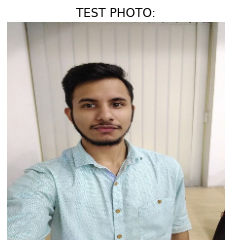

In [ ]:
show_pred_img("https://static.hub.91mobiles.com/wp-content/uploads/2016/08/Indoor-nexus-6p.jpg")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Selfie : 56 %
Outdoor Selfie : 40 %
Indoor Pose : 5 %
Outdoor Pose : 0 %
Photo Without Human : 0 %
------------------------------ 


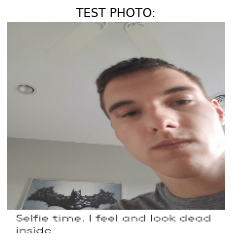

In [ ]:
show_pred_img("https://pics.me.me/selfie-time-i-feel-and-look-dead-inside-58141424.png")


------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Selfie : 85 %
Outdoor Selfie : 11 %
Indoor Pose : 4 %
Photo Without Human : 0 %
Outdoor Pose : 0 %
------------------------------ 


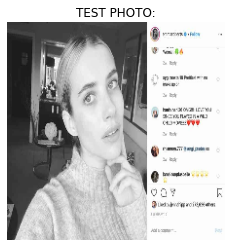

In [ ]:
show_pred_img("https://cdn.shortpixel.ai/client2/q_lossy,ret_img,w_1000,h_642/https://www.pixinfocus.com/wp-content/uploads/2020/03/selfie-ideas-103.jpg")


------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 52 %
Indoor Selfie : 46 %
Outdoor Selfie : 2 %
Outdoor Pose : 0 %
Photo Without Human : 0 %
------------------------------ 


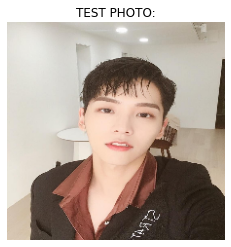

In [ ]:
show_pred_img("https://i.pinimg.com/originals/7e/46/a5/7e46a58bc6df64fd396d0ac2fbc36715.jpg")


------------------------------ 
PREDICTIONS:
------------------------------ 
Outdoor Selfie : 94 %
Photo Without Human : 5 %
Outdoor Pose : 1 %
Indoor Pose : 0 %
Indoor Selfie : 0 %
------------------------------ 


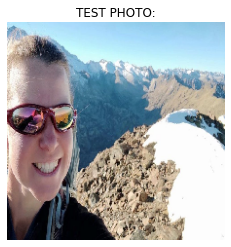

In [ ]:
show_pred_img("https://ichef.bbci.co.uk/news/976/cpsprodpb/A260/production/_115686514_29f63140-028e-4e73-b6e2-cd50798531c5.jpg")


------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 76 %
Indoor Selfie : 23 %
Outdoor Pose : 1 %
Outdoor Selfie : 1 %
Photo Without Human : 0 %
------------------------------ 


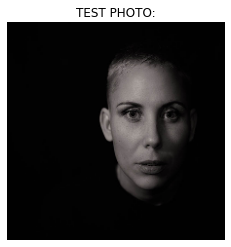

In [ ]:
show_pred_img("https://media.teds.com.au/media/gene-bluefoot/i/n/indoor-portraits-3.jpg")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 87 %
Outdoor Pose : 7 %
Photo Without Human : 4 %
Indoor Selfie : 1 %
Outdoor Selfie : 0 %
------------------------------ 


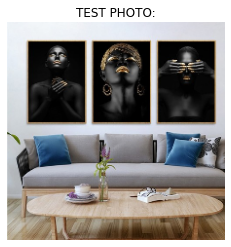

In [ ]:
show_pred_img("https://res.cloudinary.com/webstore/image/fetch/w_500,c_limit,c_fit,f_auto,e_trim/http%3A%2F%2Fluckyretail.com%2FUploadfile%2F202008091%2F450865%2F450865-5.jpg")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 58 %
Photo Without Human : 18 %
Outdoor Pose : 12 %
Indoor Selfie : 11 %
Outdoor Selfie : 2 %
------------------------------ 


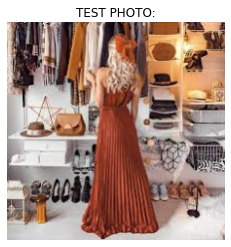

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRhXbTD9FqtGoBPXcJjHVO3rRjU5vf3TycvKA&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 89 %
Indoor Selfie : 10 %
Outdoor Pose : 0 %
Outdoor Selfie : 0 %
Photo Without Human : 0 %
------------------------------ 


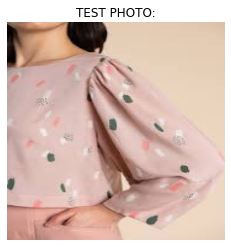

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9Pr1yMlPc8-SA6q_EGXsZT68dTSay05NRKQ&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Photo Without Human : 99 %
Outdoor Pose : 1 %
Indoor Pose : 1 %
Indoor Selfie : 0 %
Outdoor Selfie : 0 %
------------------------------ 


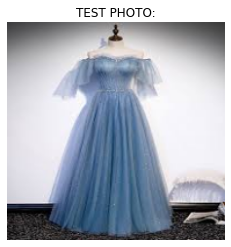

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ9HngqVDmQk-VlEHPVUHyT2zH39nCMBgYYeQ&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 77 %
Indoor Selfie : 14 %
Outdoor Pose : 4 %
Outdoor Selfie : 3 %
Photo Without Human : 2 %
------------------------------ 


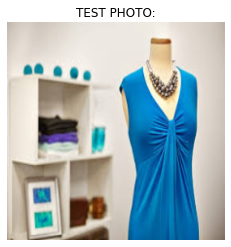

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwfV28MMlqi6zkrqNB_M_d6CUFCZG06wYQ2A&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 98 %
Outdoor Pose : 2 %
Indoor Selfie : 0 %
Photo Without Human : 0 %
Outdoor Selfie : 0 %
------------------------------ 


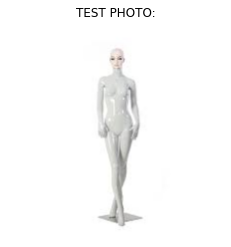

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRMZIRcfFnwtskgrecmmT2NkM9NM_jqz0eDIQ&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 87 %
Outdoor Pose : 12 %
Indoor Selfie : 0 %
Photo Without Human : 0 %
Outdoor Selfie : 0 %
------------------------------ 


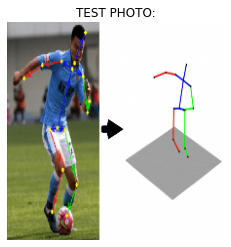

In [ ]:
show_pred_img("https://test.neurohive.io/wp-content/uploads/2018/07/3D-pose-out-of-2D-image-e1531734971331.png")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 96 %
Outdoor Pose : 4 %
Indoor Selfie : 0 %
Photo Without Human : 0 %
Outdoor Selfie : 0 %
------------------------------ 


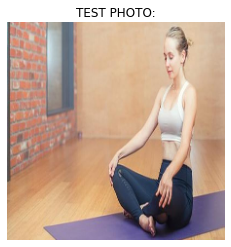

In [ ]:
show_pred_img("https://s3.ap-southeast-1.amazonaws.com/images.deccanchronicle.com/dc-Cover-14ipgp97jj28hpvpls0itnmhg3-20190723133125.Medi.jpeg")

------------------------------ 
PREDICTIONS:
------------------------------ 
Outdoor Selfie : 60 %
Indoor Selfie : 34 %
Indoor Pose : 5 %
Outdoor Pose : 0 %
Photo Without Human : 0 %
------------------------------ 


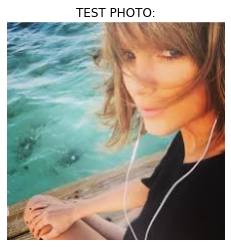

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTangUPodkOxI9Pq6_6IVUpJFLUhvNGWaiDCw&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Indoor Pose : 87 %
Outdoor Pose : 7 %
Photo Without Human : 5 %
Indoor Selfie : 1 %
Outdoor Selfie : 0 %
------------------------------ 


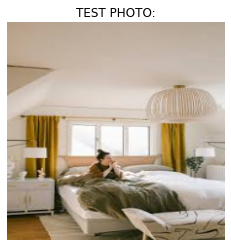

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRZK1qw4imvU_MEd1XOrGFm52c3tWIt25Wnvg&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Photo Without Human : 64 %
Indoor Pose : 27 %
Outdoor Pose : 7 %
Indoor Selfie : 2 %
Outdoor Selfie : 0 %
------------------------------ 


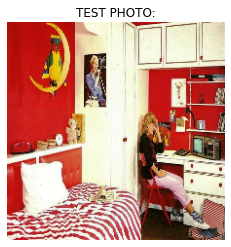

In [ ]:
show_pred_img("https://loveincorporated.blob.core.windows.net/contentimages/gallery/899ade11-a1da-4b45-afbd-aae68d540a7c-covers-ed-and-white-bedroom.jpg")

------------------------------ 
PREDICTIONS:
------------------------------ 
Photo Without Human : 100 %
Outdoor Selfie : 0 %
Outdoor Pose : 0 %
Indoor Pose : 0 %
Indoor Selfie : 0 %
------------------------------ 


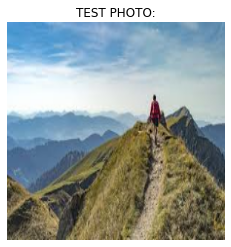

In [ ]:
show_pred_img("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTzRzrVeqG9Axr3A-nTDLD8yAjrS_VZzfBXYA&usqp=CAU")

------------------------------ 
PREDICTIONS:
------------------------------ 
Outdoor Pose : 84 %
Indoor Pose : 8 %
Outdoor Selfie : 8 %
Photo Without Human : 0 %
Indoor Selfie : 0 %
------------------------------ 


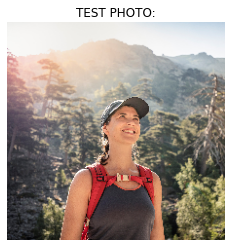

In [ ]:
show_pred_img("https://static.onecms.io/wp-content/uploads/sites/35/2020/11/23/hiking-benefits-promo.jpg")

------------------------------ 
PREDICTIONS:
------------------------------ 
Outdoor Selfie : 98 %
Photo Without Human : 1 %
Outdoor Pose : 0 %
Indoor Pose : 0 %
Indoor Selfie : 0 %
------------------------------ 


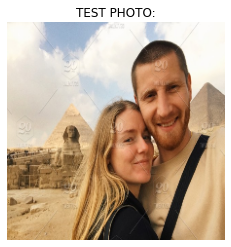

In [ ]:
show_pred_img("https://res.cloudinary.com/twenty20/private_images/t_watermark-criss-cross-10/v1621445372000/photosp/0ca44e4d-12ba-4b9f-9012-8b37a2f462c4/stock-photo-outdoors-travel-couple-egypt-pyramid-selfie-outdoor-pyramids-outdoor-activity-0ca44e4d-12ba-4b9f-9012-8b37a2f462c4.jpg")